In [1]:
# !pip install git+https://github.com/Geosyntec/cloudside.git

In [2]:
import numpy
import pandas
from matplotlib import pyplot
import seaborn

from metar.Metar import Metar
import cloudside 

seaborn.set_style('ticks')
%matplotlib inline


In [3]:
lines = open("KPDX.txt").readlines()
kpdx = []
for line in lines:
    m = Metar(line)
    if m.wind_dir:
        kpdx.append({
            "Date": m.time,
            "Sta": m.station_id,
            "WindSpd": m.wind_speed.value(),
            "WindDir": m.wind_dir.value(),
        })
kpdx = pandas.DataFrame.from_records(kpdx)
kpdx

,Date,Sta,WindSpd,WindDir
0,2023-08-02 11:53:00,KPDX,3.0,50.0
1,2023-08-02 10:53:00,KPDX,3.0,320.0
2,2023-08-02 09:53:00,KPDX,0.0,0.0
3,2023-08-02 08:53:00,KPDX,4.0,340.0
4,2023-08-02 07:53:00,KPDX,5.0,310.0
...,...,...,...,...
155,2023-08-08 19:53:00,KPDX,6.0,180.0
156,2023-08-08 20:53:00,KPDX,5.0,180.0
157,2023-08-08 21:53:00,KPDX,5.0,170.0
158,2023-08-08 22:53:00,KPDX,11.0,200.0


In [4]:
total_count = kpdx.shape[0]
calm_count = kpdx.query("WindSpd == 0").shape[0]

print('Of {} total observations, {} have calm winds.'.format(total_count, calm_count))


Of 160 total observations, 8 have calm winds.


In [5]:
def speed_labels(bins, units):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif numpy.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))

    return list(labels)


In [6]:
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * numpy.pi/180. - numpy.pi/N
    barWidth = 2 * numpy.pi / N
    return barDir, barWidth


In [7]:
spd_bins = [-1, 0, 5, 10, 15, 20, 25, 30, numpy.inf]
spd_labels = speed_labels(spd_bins, units='knots')

dir_bins = numpy.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2


In [8]:
rose = (
    kpdx.assign(WindSpd_bins=lambda df:
            pandas.cut(df['WindSpd'], bins=spd_bins, labels=spd_labels, right=True)
         )
        .assign(WindDir_bins=lambda df:
            pandas.cut(df['WindDir'], bins=dir_bins, labels=dir_labels, right=False)
         )
        .replace({'WindDir_bins': {360: 0}})
        .groupby(by=['WindSpd_bins', 'WindDir_bins'])
        .size()
        .unstack(level='WindSpd_bins')
        .fillna(0)
        .assign(calm=lambda df: calm_count / df.shape[0])
        .sort_index(axis=1)
        .applymap(lambda x: x / total_count * 100)
)


In [9]:
def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = seaborn.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = pyplot.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig


In [10]:
rose

WindSpd_bins,calm,0 - 5 knots,5 - 10 knots,10 - 15 knots,15 - 20 knots,20 - 25 knots,25 - 30 knots,>30 knots
WindDir_bins,,,,,,,,
0.0,0.208333,0.625,1.250,0.000,0.0,0.0,0.0,0.0
15.0,0.208333,0.000,0.000,0.000,0.0,0.0,0.0,0.0
30.0,0.208333,0.625,0.000,0.000,0.0,0.0,0.0,0.0
45.0,0.208333,0.625,0.000,0.000,0.0,0.0,0.0,0.0
60.0,0.208333,0.625,0.000,0.000,0.0,0.0,0.0,0.0
75.0,0.208333,0.000,0.625,0.000,0.0,0.0,0.0,0.0
90.0,0.208333,0.000,0.000,0.000,0.0,0.0,0.0,0.0
105.0,0.208333,1.250,2.500,0.000,0.0,0.0,0.0,0.0
120.0,0.208333,1.875,3.125,0.000,0.0,0.0,0.0,0.0


In [11]:
directions

NameError: name 'directions' is not defined

/tmp/ipykernel_11657/1768344471.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


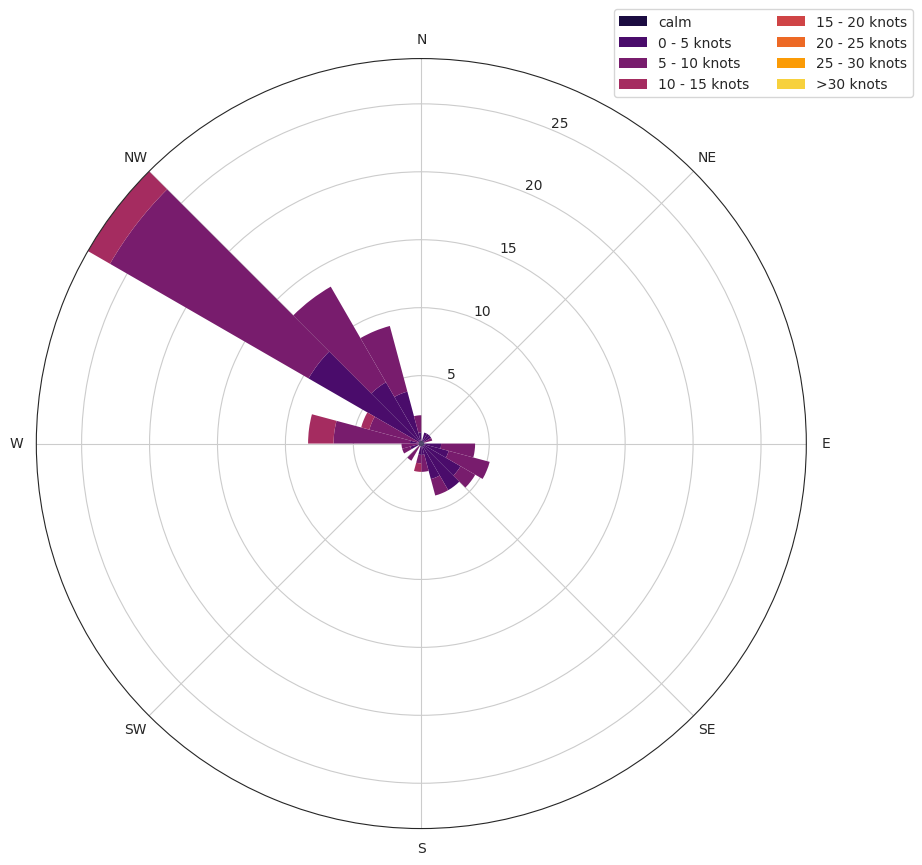

In [ ]:
directions = numpy.arange(0, 360, 15)
fig = wind_rose(rose, directions)
